In [9]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,\
mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn import svm, linear_model
import joblib
import os

### Importing brute datasets (manually downloaded from the IBGE page -- in an awful artisanal format, not appropriate for manipulation at all -- and manually editted on excel to allow pd.read to work, for now)

In [2]:
votes = pd.read_csv('./Elections_results.csv', encoding='latin-1', sep=';')
census = pd.read_excel('./Census.xlsx')
domestic = pd.read_excel('./Domestic_arrangement.xls')
revenue = pd.read_excel('./Revenue_per_person.xls')

In [3]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 26 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DT_GERACAO                 object
 1   HH_GERACAO                 object
 2   ANO_ELEICAO                int64 
 3   CD_TIPO_ELEICAO            int64 
 4   NM_TIPO_ELEICAO            object
 5   NR_TURNO                   int64 
 6   CD_ELEICAO                 int64 
 7   DS_ELEICAO                 object
 8   DT_ELEICAO                 object
 9   TP_ABRANGENCIA             object
 10  SG_UF                      object
 11  SG_UE                      object
 12  NM_UE                      object
 13  CD_MUNICIPIO               int64 
 14  NM_MUNICIPIO               object
 15  NR_ZONA                    int64 
 16  NR_SECAO                   int64 
 17  CD_CARGO                   int64 
 18  DS_CARGO                   object
 19  NR_VOTAVEL                 int64 
 20  NM_VOTAVEL              

In [4]:
votes[['NR_VOTAVEL','NM_VOTAVEL']].value_counts()

NR_VOTAVEL  NM_VOTAVEL                         
13          LUIZ INÁCIO LULA DA SILVA              944046
22          JAIR MESSIAS BOLSONARO                 943747
96          VOTO NULO                              929950
95          VOTO BRANCO                            882861
12          CIRO FERREIRA GOMES                    462777
15          SIMONE NASSAR TEBET                    459481
44          SORAYA VIEIRA THRONICKE                306862
30          LUIZ FELIPE CHAVES D AVILA             249586
14          KELMON LUIS DA SILVA SOUZA              72364
80          LEONARDO PÉRICLES VIEIRA ROQUE          47204
21          SOFIA PADUA MANZANO                     41799
16          VERA LUCIA PEREIRA DA SILVA SALGADO     24196
27          JOSE MARIA EYMAEL                       15863
dtype: int64

In [5]:
# We must immediately process the votes dataset, otherwise we would have too many rows to process:
# one for each candidate (including representatives and etc.) for each voting section of each city,
# ammounting to more than 5gbs of memory
def process_votes(dataset):
    
    new_dataset = dataset.copy()
    
    new_dataset = new_dataset[((dataset['NR_VOTAVEL'] == 22) | (new_dataset['NR_VOTAVEL'] == 13)) & \
            (new_dataset['NR_TURNO'] == 2)]
    
    new_dataset = (new_dataset.groupby(['NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL','NR_TURNO','SG_UF'], as_index=False)\
                   ['QT_VOTOS'].sum())\
                   .merge(new_dataset.groupby(['NM_MUNICIPIO','SG_UF'], as_index=False)['QT_VOTOS'].sum(), \
                   on=['NM_MUNICIPIO', 'SG_UF'], how='left', suffixes=('', '_SUM'))

    new_dataset.rename(columns={'QT_VOTOS_SUM': 'VALID_TOT'}, inplace=True)
    
    new_dataset = new_dataset[new_dataset['NR_VOTAVEL'] == 22]
    
#    new_dataset[(new_dataset['NR_VOTAVEL'] == 95) | (new_dataset['NR_VOTAVEL'] == 96)]['NR_VOTAVEL'] = 'Invalid'
    
    new_dataset['VOTOS_P100'] = new_dataset['QT_VOTOS']/new_dataset['VALID_TOT']
    
#     if drop_invalid_votes:
#         new_dataset = new_dataset[new_dataset['NR_VOTAVEL'] == 22]
    
    new_dataset.drop(['NM_VOTAVEL','NR_TURNO','QT_VOTOS','VALID_TOT'], axis=1,inplace=True)
    
    return(new_dataset)



# Also need text processing to match different conventions of different datasets
# Inputting the ' correctly; Removing the hyphens; Applying unicode to the `NOME` column and making it uppercase
def specific_text_processer(dataset):
    
    dataset.rename(columns={'NM_MUNICIPIO': 'NOME'}, inplace=True)
    dataset.replace({'&apos;': ' '}, regex=True,inplace=True)
    dataset.replace({'-': ' '}, regex=True,inplace=True)
    dataset.replace({'\'': ' '}, regex=True,inplace=True)
    dataset['NOME'] = dataset['NOME'].apply(unidecode)
    dataset['NOME'] = dataset['NOME'].str.upper()
    dataset.rename(columns={'SIGLA_UF': 'SG_UF'}, inplace=True)

    dataset.loc[dataset['NOME'] == 'ALVORADA D OESTE', 'NOME'] = 'ALVORADA DO OESTE'
    dataset.loc[dataset['NOME'] == 'ARES', 'NOME'] = 'AREZ'
    dataset.loc[dataset['NOME'] == 'BRASOPOLIS', 'NOME'] = 'BRAZOPOLIS'
    dataset.loc[dataset['NOME'] == 'CAMACAN', 'NOME'] = 'CAMACA'
    dataset.loc[dataset['NOME'] == 'EMBU', 'NOME'] = 'EMBU DAS ARTES'
    dataset.loc[dataset['NOME'] == 'ESPIGAO D OESTE', 'NOME'] = 'ESPIGAO DO OESTE'
    dataset.loc[dataset['NOME'] == 'FLORINIA', 'NOME'] = 'FLORINEA'
    dataset.loc[dataset['NOME'] == 'GRACHO CARDOSO', 'NOME'] = 'GRACCHO CARDOSO'
    dataset.loc[dataset['NOME'] == 'IGUARACI', 'NOME'] = 'IGUARACY'
    dataset.loc[dataset['NOME'] == 'ITAPAGE', 'NOME'] = 'ITAPAJE'
    dataset.loc[dataset['NOME'] == 'MOJI MIRIM', 'NOME'] = 'MOGI MIRIM'
    dataset.loc[dataset['NOME'] == 'MUQUEM DE SAO FRANCISCO', 'NOME'] = 'MUQUEM DO SAO FRANCISCO'
    dataset.loc[dataset['NOME'] == 'POXOREO', 'NOME'] = 'POXOREU'

In [6]:
# Drop useless columns
useless_columns = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','CD_TIPO_ELEICAO','NM_TIPO_ELEICAO','CD_ELEICAO',\
               'DS_ELEICAO','DT_ELEICAO','TP_ABRANGENCIA','SG_UE','NM_UE','CD_MUNICIPIO','NR_ZONA','NR_SECAO',\
              'CD_CARGO','DS_CARGO','NR_LOCAL_VOTACAO','SQ_CANDIDATO',\
              'NM_LOCAL_VOTACAO','DS_LOCAL_VOTACAO_ENDERECO']
votes = votes.drop(useless_columns, axis=1)


# Below we process the votes dataset (including the aggregations to remove amount of data)
votes = process_votes(votes)
specific_text_processer(votes)
    
    
# Keep only the last census data
# Text processing of the census dataset

census = census[census['ANO']==2017]
specific_text_processer(census)


# We add a `SG_UF` column to the `census` database, to be able to correctly match the cities
# This is done understanding how the IBGE7 column must be interpreted
# Each city is given a 7-digits code. The 2 first digits is paired with its state

code_to_SG = {12: 'AC', 27: 'AL', 16: 'AP', 13: 'AM', 29: 'BA', 23: 'CE', 53: 'DF', \
             32: 'ES', 52: 'GO', 21: 'MA', 51: 'MT', 50: 'MS', 31: 'MG', 15: 'PA', 25: 'PB', \
             41: 'PR', 26: 'PE', 22: 'PI', 24: 'RN', 43: 'RS', 33: 'RJ', 11: 'RO', 14: 'RR', \
             42: 'SC', 35: 'SP', 28: 'SE', 17: 'TO'}
census['SG_UF'] = census['IBGE7'] // 100000
census['SG_UF'] = census['SG_UF'].replace(code_to_SG)


specific_text_processer(domestic)
specific_text_processer(revenue)


revenue[['1_QUART','2_QUART','3_QUART']] = revenue[['1_QUART','2_QUART','3_QUART']].apply(\
                        lambda x: x/x.sum(), axis=1)

### We merge the datasets now, using the city name and UF as anchor

In [7]:
final_data = votes.merge(census, on=['NOME','SG_UF'], how='inner').\
merge(domestic, on=['NOME','SG_UF'], how='inner').merge(revenue, on=['NOME','SG_UF'], how='inner')

In [8]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5554 entries, 0 to 5553
Data columns (total 94 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NOME               5554 non-null   object 
 1   NR_VOTAVEL         5554 non-null   int64  
 2   SG_UF              5554 non-null   object 
 3   VOTOS_P100         5554 non-null   float64
 4   ANO                5554 non-null   int64  
 5   DESAGREGACAO       5554 non-null   object 
 6   IBGE7              5554 non-null   int64  
 7   PMATPUB_EF         5554 non-null   float64
 8   PMATPUB_EM         5545 non-null   float64
 9   PMATPRI_EF         3012 non-null   float64
 10  PMATPRI_EM         1576 non-null   float64
 11  DIST_EF_TOTAL      5554 non-null   float64
 12  DIST_EM_TOTAL      5544 non-null   float64
 13  DIST_EF_PRI        2633 non-null   float64
 14  DIST_EM_PRI        1575 non-null   float64
 15  DIST_EF_PUB        5554 non-null   float64
 16  DIST_EM_PUB        5544 

### We can test that there isn't many cities left out

In [9]:
votes = votes[~votes['NOME'].isin(final_data['NOME'].tolist())]
census = census[~census['NOME'].isin(final_data['NOME'].tolist())]

votes = votes.sort_values('NOME')
census = census.sort_values('NOME')

unmatched_municipios = census[~census['NOME'].isin(votes['NOME'])]

unmatched_municipios

,ANO,DESAGREGACAO,IBGE7,NOME,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,PMATPRI_EM,DIST_EF_TOTAL,DIST_EM_TOTAL,...,PFOCOS,PFLORA,PFEM_VEREADOR,PFEM_PREFEITO,PFEM_GOVERNADOR,PFEM_DEP_ESTADUAL,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT,SG_UF
23356,2017,TOTAL,2400208,ACU,73.16,74.82,26.84,25.18,24.0,38.5,...,0.01,50.65,26.67,0.0,NaN,NaN,NaN,NaN,58183,RN
23367,2017,TOTAL,2401305,AUGUSTO SEVERO,98.30,100.00,1.70,NaN,28.5,44.2,...,0.00,55.54,55.56,0.0,NaN,NaN,NaN,NaN,9768,RN
22644,2017,TOTAL,1708254,FORTALEZA DO TABOCAO,100.00,100.00,NaN,NaN,12.5,25.3,...,0.03,49.56,11.11,0.0,NaN,NaN,NaN,NaN,2584,TO
23413,2017,TOTAL,2405306,JANUARIO CICCO,96.37,100.00,3.63,NaN,33.8,55.8,...,0.00,12.92,55.56,100.0,NaN,NaN,NaN,NaN,10096,RN
23721,2017,TOTAL,2515401,SERIDO,97.99,100.00,2.01,NaN,23.1,43.5,...,NaN,36.76,11.11,100.0,NaN,NaN,NaN,NaN,11084,PB


### We can also test that there isn't repeated cities (same name and same UF) in the relevant dataset

In [10]:
final_data[final_data.duplicated(subset=['NOME','SG_UF'], keep=False)]

,NOME,NR_VOTAVEL,SG_UF,VOTOS_P100,ANO,DESAGREGACAO,IBGE7,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,...,POP_TOT,PCNT_UNIPEOPLE,CHILDLESS_COUPLE,COUPLE_W_CHILDREN,MAN_W_CHILDREN,WOMAN_W_CHILDREN,REV_MEAN,1_QUART,2_QUART,3_QUART


### Eliminating federal capital

In [11]:
final_data.drop(final_data[final_data['SG_UF']=='DF'].index, inplace=True)

In [12]:
len(final_data)

5553

### We drop the features which have excessively many missing values (of course, the lines below could be trivially automatized)

In [13]:
# We drop every column with too many missing values along with meaningless values `desagregacao` and `ibge7`

features_to_drop = ['PMATPRI_EF','PMATPRI_EM','DIST_EF_PRI','DIST_EM_PRI','TTREVA_EF_TOTAL','TTREVA_EM_TOTAL',\
                'TTREVA_EF_PRI','TTREVA_EM_PRI','TTREVA_EF_PUB','TTREVA_EM_PUB','DOCSUP_EF_PRI',\
                'DOCSUP_EM_PRI','TXMOCANMA','TXMOATRA','TXMOSUI','TXMOAGR','REN_PIBPC_D','REN_VAPC_D',\
                'REN_PVAAGR','TXOBITMATERN','TXMAE10A14','REN_PVAIND','REN_PVAADM','REN_PVASERV',\
                'SNIS_PESGOTO','SNIS_PESGTRA','SNIS_PCOLSEL','SNIS_CDI','PFEM_GOVERNADOR',\
                'PFEM_DEP_ESTADUAL','PFEM_DEP_FEDERAL','PFEM_SENADOR','DESAGREGACAO','IBGE7']


final_data.drop(features_to_drop, axis=1,inplace=True)

### Finalizing the preprocessing and saving the processed datasets

In [6]:
X = final_data.drop(['NOME','NR_VOTAVEL','ANO','VOTOS_P100'], axis=1)
y = final_data['VOTOS_P100']
X.columns = X.columns.astype(str)

X.to_json('./preprocessed_elections_data_X.json', orient='records')
y.to_json('./preprocessed_elections_data_y.json', orient='records')

NameError: name 'final_data' is not defined

### Below we define our custom transformers to use on pipelines

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



class Encoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat_attributes=None, encoder_arg='one_hot'):
        self.encoder_arg = encoder_arg
        self.cat_attributes = cat_attributes
        
    def fit(self, X, y=None):
        cat_cols = X[self.cat_attributes]
        if self.encoder_arg == 'one_hot':
            self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(cat_cols)
        return self
    
    def transform(self, X, y=None):
        encoded_df = pd.DataFrame(self.encoder.transform(X[self.cat_attributes]))
        df = pd.concat([X.drop(self.cat_attributes, axis=1), encoded_df], axis=1)
        df.columns = df.columns.astype(str)
        return df

    

class Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, fill_with=0):
        self.fill_with = fill_with
        self.imputer = None
        
    def fit(self, X, y=None):
        self.imputer = self.fill_with
        return self
    
    def transform(self, X, y=None):
        df = X.copy().reset_index(drop=True)
        #df = X.copy()
        if self.imputer == 'median':
            return df.fillna(df.median())
        else:
            return df.fillna(self.imputer)
    
    def get_params(self, deep=True):
        return {'fill_with': self.fill_with}

    
    
class PolyTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, degree=2, cat_attributes=[], no_higher_powers=False, \
                 rename=False, include_bias=True):
        self.degree = degree
        self.cat_attributes = cat_attributes
        self.no_higher_powers= no_higher_powers
        self.feature_names_in_ = None
        self.rename = rename
        self.include_bias=include_bias
        
    def fit(self, X, y=None):
        self.transformer = PolynomialFeatures(degree=self.degree, \
                interaction_only=self.no_higher_powers, include_bias=self.include_bias)
        self.df_num_cols = list(set(X.columns)-set(self.cat_attributes))
        df_num = X[self.df_num_cols]
        self.transformer.fit(df_num)
        return self
    
    def transform(self, X, y=None):
        df_num = X[self.df_num_cols]
        df_num_squared = pd.DataFrame(self.transformer.transform(df_num))
        if self.rename == True:
            old_columns = df_num_squared.columns
            new_columns = self.transformer.get_feature_names_out(df_num.columns)
            column_mapping = {old_col: new_col for old_col, new_col in zip(old_columns, new_columns)}
            df_num_squared = df_num_squared.rename(columns= column_mapping) 
            self.squared_cols = df_num_squared.columns
        df_cat = X[self.cat_attributes]
        df_combined = pd.DataFrame(df_num_squared).join(pd.DataFrame(df_cat))
        return df_combined
    
    def get_feature_names(self):
        return self.transformer.get_feature_names_out(input_features=self.df_num_cols)
    
    def get_coefs_df(self, estimator):
        coefs_df = pd.DataFrame(0, index=self.df_num_cols, columns=self.df_num_cols)
        coefs_df.loc['1'] = 0
        coefs_df['1'] = 0
        linear_features = coefs_df.columns
        coefs = estimator.coef_
        len_classes = len(self.squared_cols)
        coefs = coefs[:len_classes]
        coef_feature = pd.DataFrame({'Feature':self.squared_cols, 'Coefficient':coefs})\
                .sort_values(by='Coefficient', key=abs, ascending=False)
        
        for index, row in coef_feature.iterrows():
            for column_original_1 in linear_features:
                for column_original_2 in linear_features:
                    if (column_original_1 in row['Feature']) and (column_original_2 in row['Feature'])\
                    and column_original_1 != column_original_2:
                        coefs_df.loc[column_original_1, column_original_2] = row['Coefficient']
                        coefs_df.loc[column_original_2, column_original_1] = row['Coefficient']
                    
                    if (column_original_1 == column_original_2) and (column_original_2 in row['Feature'])\
                    and ('^' in row['Feature']):
                        coefs_df.loc[column_original_1, column_original_1] = row['Coefficient']
                        
                    if (column_original_1 == '1') and column_original_1 != column_original_2\
                    and (column_original_2 == row['Feature']):
                        coefs_df.loc[column_original_1, column_original_2] = row['Coefficient']
                        coefs_df.loc[column_original_2, column_original_1] = row['Coefficient']
                        
                    if (column_original_2 == '1') and column_original_1 != column_original_2\
                    and (column_original_1 == row['Feature']):
                        coefs_df.loc[column_original_1, column_original_2] = row['Coefficient']
                        coefs_df.loc[column_original_2, column_original_1] = row['Coefficient']
        
        # Note that the 1-1 cell is the bias term!!!
        
                    if (column_original_2 == '1') and (column_original_1 == '1')\
                    and (column_original_1 == row['Feature']):
                        coefs_df.loc[column_original_1, column_original_1] = row['Coefficient']
        
        return coefs_df
    

    
class Scaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler_type='standard', output_type=None):
        self.scaler_type = scaler_type
        self.output_type=output_type
        if output_type=='dataframe':
            self.output_type='pandas'
        
    def fit(self, X, y=None):
        if self.scaler_type == 'standard':
            self.transformer = StandardScaler().set_output(transform=self.output_type)
        elif self.scaler_type == 'minmax':
            self.transformer = MinMaxScaler().set_output(transform=self.output_type)
        self.transformer.fit(X)
        return self
    
    def transform(self, X, y=None):
        df = self.transformer.transform(X)
        return df

### We also define some custom evaluators

In [5]:
def evaluate_preds_class(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

def evaluate_preds_number(model, X_test, y_test):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    
    y_preds = model.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_preds)
    MAE = mean_absolute_error(y_test, y_preds)
    R2 = r2_score(y_test, y_preds)
    exp_score = explained_variance_score(y_test, y_preds)
    metric_dict = {"MSE": round(MSE, 5),"MAE": round(MAE, 5),
                   "R2": round(R2, 5), "Score": exp_score}
#    print(f"Mean absolute error: {MAE:.4f}")
#    print(f"R-squared: {R2:.4f}")

    return metric_dict

# Load the stored preprocessed dataframe

In [14]:
X = pd.read_json('C:/Users/betob/Dropbox/Data_Science/Projects/2 -- Elections 2022/preprocessed_elections_data_X.json')
y = pd.read_json('C:/Users/betob/Dropbox/Data_Science/Projects/2 -- Elections 2022/preprocessed_elections_data_y.json')

# Now it is time for some Machine Learning
---------------------------------
### In this first stage of this project, we shall only find the best model accross some of the most obvious candidates, i.e., we shall tune and search for the best:

1. _Random Forest Regressor_: Ensemble Decision Trees are always a great place to start!
2. _Linear Model (featuring ElasticNet regularization)_: Linear models, specially with a Random Forest Regressor to compare, are an amazing source of intuition regarding the difficulty of the problem at hand.
3. _Squared Model (featuring ElasticNet regularization)_: Simply a better version (although much more prone to overfitting and much more computationally demanding) of the Linear Model.

## 1. _Random Forest Regressor_ 

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

imputing = Imputer()
encoder = Encoder(cat_attributes=['SG_UF'])
std_scaler = StandardScaler()
model_rfr = RandomForestRegressor(n_estimators = 100)

pipeline_rfr = Pipeline([('imputing', imputing),('encoder', encoder),\
                         ('scaler', std_scaler), ('model', model_rfr)])

grid_params_rfr = {'model__min_samples_split': [2,3,4,5,6],
              'model__min_samples_leaf': [2,3,4,5,6],
              'model__max_features': [1.0, 35, 40, 45],
              'model__criterion': ['friedman_mse'],
              'imputing__fill_with': [0, 'median'],
              'encoder__encoder_arg': ['one_hot']}
random_search_rfr = GridSearchCV(pipeline_rfr, grid_params_rfr,  cv=5, n_jobs=-1)
random_search_rfr.fit(X_train, y_train)

best_model_rfr = random_search_rfr.best_estimator_

C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [59]:
random_search_rfr.best_params_

NameError: name 'random_search_rfr' is not defined

In [10]:
random_search_rfr.best_score_

0.8395049759489799

In [11]:
rfr_score = best_model_rfr.score(X_test, y_test)
rfr_score

0.8412141137043954

## 2.1. _ElasticNet Linear Model_ 

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

imputing = Imputer()
encoder = Encoder(cat_attributes=['SG_UF'])
std_scaler = StandardScaler()
elastic_net = ElasticNet(max_iter=1000, tol=1e-3)

params_grid_el_net = {
'model__alpha': np.logspace(-7, -3, 40),  # Range of alpha values to search over (regularization strength)
'model__l1_ratio': np.linspace(0.7,0.95,60), # 0 for L2 penalty, 1 for L1 penalty
'imputing__fill_with': [0, 'median'],
'encoder__encoder_arg': ['one_hot']
}

std_scaler = StandardScaler()
pipeline = Pipeline([('imputing', imputing),('encoder', encoder), ('scaler', std_scaler), ('model', elastic_net)])

random_search = GridSearchCV(pipeline, params_grid_el_net,  cv=5, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

C:\Users\betob\AppData\Local\Temp\ipykernel_26116\1753367088.py:62: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.fillna(df.median())
C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
random_search.best_params_

{'encoder__encoder_arg': 'one_hot',
 'imputing__fill_with': 'median',
 'model__alpha': 3.665241237079626e-05,
 'model__l1_ratio': 0.7762711864406779}

In [15]:
random_search.best_score_

0.8497408958237702

In [16]:
best_model = random_search.best_estimator_

el_net_score = best_model.score(X_test, y_test)
el_net_score

C:\Users\betob\AppData\Local\Temp\ipykernel_26116\1753367088.py:62: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.fillna(df.median())


0.8530531652777973

## 2.1. _ElasticNet Linear Model: test removing the state feature_ 

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X_wo_state = X.drop(X.columns[X.columns.str.isnumeric()], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_wo_state, y, test_size=0.2, shuffle=True)

params_grid_el_net = {
'model__alpha': np.logspace(-7, -4, 25),  # Range of alpha values to search over (regularization strength)
'model__l1_ratio': np.linspace(0.7,0.95,50) # 0 for L2 penalty, 1 for L1 penalty
}

elastic_net = ElasticNet(max_iter=4000, tol=1e-3)

std_scaler = StandardScaler()
pipeline = Pipeline([('scaler', std_scaler), ('model', elastic_net)])

random_search = GridSearchCV(pipeline, params_grid_el_net,  cv=5, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

In [33]:
random_search.best_params_

{'model__alpha': 4.216965034285822e-05, 'model__l1_ratio': 0.7663265306122449}

In [34]:
random_search.best_score_

0.782053068028947

In [35]:
best_model = random_search.best_estimator_

el_net_score = best_model.score(X_test, y_test)
el_net_score

0.7970094649140127

## 3. _ElasticNet Squared Model_: our custom transformer deals with not squaring the 26-classes categorical feature 

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Create an ElasticNetCV model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

cat_columns = ['SG_UF']
imputing = Imputer()
squarer = PolyTransformer(cat_attributes=cat_columns)
encoder = Encoder(cat_attributes=cat_columns)
std_scaler = StandardScaler()
elastic_net = ElasticNet(max_iter=2000, tol=1e-3)

params_grid_el_net = {
#'model__alpha': np.logspace(-2.5, -2, 6),  # Range of alpha values to search over (regularization strength)
'model__alpha': np.linspace(0.00055, 0.00075, 8), #[0.0004, 0.00065, 0.0009, 0.002],
'model__l1_ratio': np.linspace(0.65,0.75,8),#np.linspace(0.9,0.96,45), # 0 for L2 penalty, 1 for L1 penalty
'imputing__fill_with': [0, 'median'],
'encoder__encoder_arg': ['one_hot'],
'squarer__degree': [2]
}

pipeline = Pipeline([('imputing', imputing), ('squarer', squarer), ('encoder', encoder), \
                     ('scaler', std_scaler), ('model', elastic_net)])

random_search = GridSearchCV(pipeline, params_grid_el_net,  cv=5, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
random_search.best_params_

{'encoder__encoder_arg': 'one_hot',
 'imputing__fill_with': 0,
 'model__alpha': 0.0006928571428571428,
 'model__l1_ratio': 0.7357142857142858,
 'squarer__degree': 2}

In [6]:
random_search.best_score_

0.857615233911765

In [7]:
best_model = random_search.best_estimator_

el_net_squared_w_bias_score = best_model.score(X_test, y_test)
el_net_squared_w_bias_score

0.8563174880872966

In [9]:
joblib.dump(best_model, 'squared_ElNet__p8576.pkl')

['squared_ElNet__p8576.pkl']

# In the scope of this stage of this project, we will content ourselves with the model above. Among the obvious next steps that could be easily taken in order to improve it, are:

1. _Dimensionality reduction_: Could use, e.g., Principal Component Analysis (or manifold methods) to alleviate the complexity of the dataset, transforming it to a lower dimensional version of itself;
2. _Outlier treatment_: Could use, e.g., Bayesian Gaussian Mixture Matrices to rid the model of most extreme outliers (with the care to define a procedure which will not exceedingly reduce the cardinality of the data);
3. _Turn the estimator into an ensemble_: Could train a few more good models, very different than our polynomial one, and define an ensemble with their combination. We could try, to start, a kernelized SVM regressor, a Random Forest and a Logistic Regressor. These models could be ensembled through Bagging. One more step that could be taken would be to try a boosting strategy on the ensemble, particularly, the great XGBoost.

## Now for a little Data Visualization

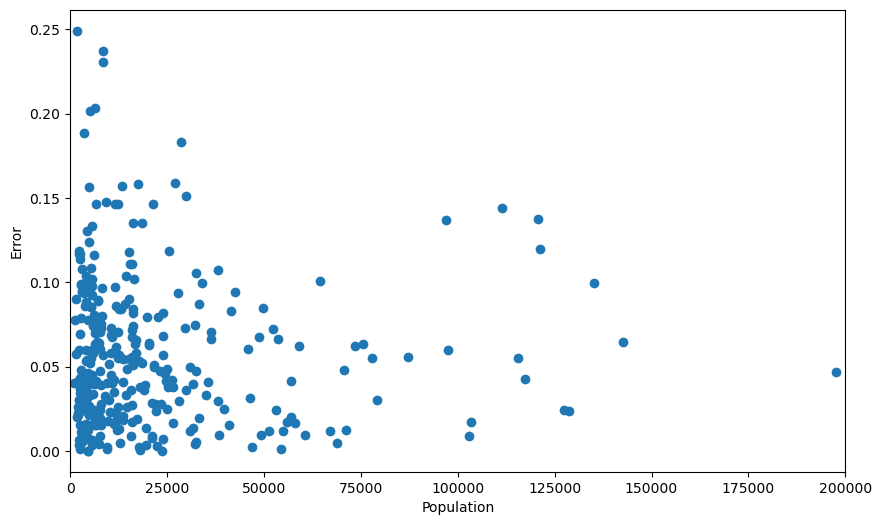

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

best_model = ElasticNet(max_iter=4000, alpha=4.436687330978607e-05, l1_ratio=0.8673684210526316)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

absolute_error = abs(y_test - y_pred)

column = 'POP_TOT'
column_new_name = 'Population'

result_df = pd.DataFrame({column_new_name: X_test[column], 'Error': absolute_error})

# Group by column values and calculate the average negative percentage error
error_distribution = result_df.groupby(column_new_name)['Error'].mean()

# Step 6: Plot the results using Matplotlib
x_min_value = 0
x_max_value = 200000

plt.figure(figsize=(10, 6))
plt.scatter(error_distribution.index, error_distribution.values)
plt.xlabel(column_new_name)
plt.ylabel('Error')
plt.xlim(x_min_value, x_max_value)
plt.show()

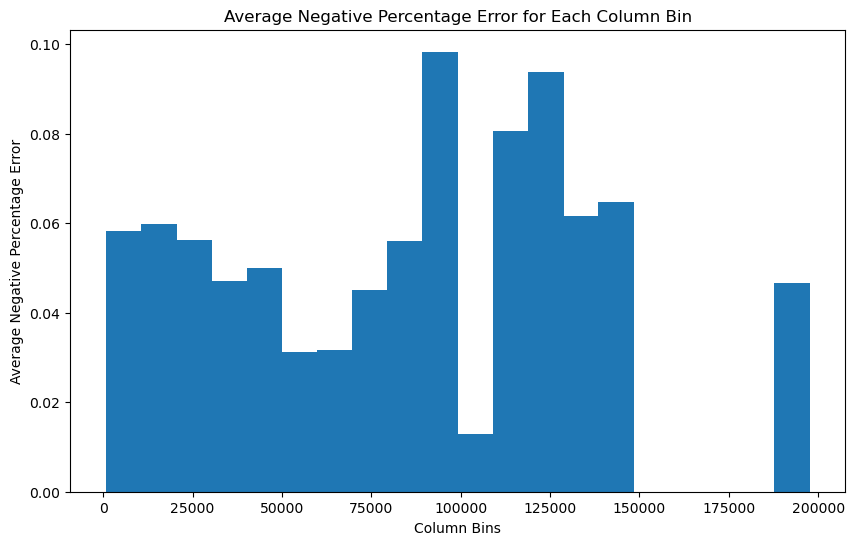

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

best_model = ElasticNet(max_iter=4000, alpha=4.436687330978607e-05, l1_ratio=0.8673684210526316)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

absolute_error = abs(y_test - y_pred)

column = 'POP_TOT'
column_new_name = 'Population'
column_bins = column_new_name+'_bins'

result_df = pd.DataFrame({column_new_name: X_test[column], 'Error': absolute_error})
result_df = result_df.loc[result_df[column_new_name] <= 200000]

# Group by column values and calculate the average negative percentage error
error_distribution = result_df.groupby(column_new_name)['Error'].mean()

num_bins = 20
result_df[column_bins] = pd.cut(result_df[column_new_name], bins=num_bins)
error_distribution_by_bin = result_df.groupby(column_bins)['Error'].mean()

bin_width = result_df[column_bins].cat.categories[0].right-result_df[column_bins].cat.categories[0].left

bin_centers = [(b.left + b.right) / 2 for b in error_distribution_by_bin.index]

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, error_distribution_by_bin.values, width=bin_width)
plt.xlabel('Column Bins')
plt.ylabel('Average Negative Percentage Error')
plt.title('Average Negative Percentage Error for Each Column Bin')
plt.show()

In [23]:
y_test.values.reshape(-1).shape

(1111,)

In [ ]:
reshape()

# Define model manually

In [15]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

params_dict = {'encoder__encoder_arg': 'one_hot',
               'imputing__fill_with': 0,
               'model__alpha': 0.0006928571428571428,
               'model__l1_ratio': 0.7357142857142858,
               'squarer__degree': 2}

cat_columns = ['SG_UF']
imputing = Imputer()
squarer = PolyTransformer(cat_attributes=cat_columns, rename=True)
encoder = Encoder(cat_attributes=cat_columns)
std_scaler = StandardScaler()
elastic_net = ElasticNet(max_iter=2000, tol=1e-3)

best_model = Pipeline([('imputing', imputing), ('squarer', squarer), ('encoder', encoder), \
                     ('scaler', std_scaler), ('model', elastic_net)])

best_model.set_params(**params_dict)

Pipeline(steps=[('imputing', Imputer()),
                ('squarer',
                 PolyTransformer(cat_attributes=['SG_UF'], rename=True)),
                ('encoder', Encoder(cat_attributes=['SG_UF'])),
                ('scaler', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.0006928571428571428,
                            l1_ratio=0.7357142857142858, max_iter=2000,
                            tol=0.001))])

C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


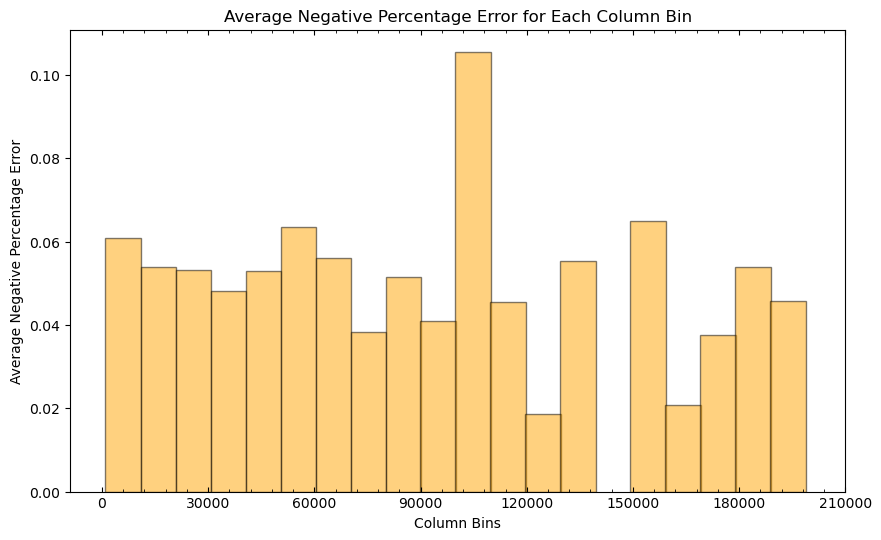

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.ticker as ticker

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# best_model = ElasticNet(max_iter=4000, alpha=4.436687330978607e-05, l1_ratio=0.8673684210526316)
# best_model = joblib.load('C:/Users/betob/Dropbox/Data_Science/Projects/2 -- Elections 2022/squared_ElNet__p8576.pkl')

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

absolute_error = abs(y_test.values.reshape(-1) - y_pred)

column = 'POP_TOT'
column_new_name = 'Population'
column_bins = column_new_name+'_bins'

result_df = pd.DataFrame({column_new_name: X_test[column], 'Error': absolute_error})
result_df = result_df.loc[result_df[column_new_name] <= 200000]

# Group by column values and calculate the average negative percentage error
error_distribution = result_df.groupby(column_new_name)['Error'].mean()

num_bins = 20
result_df[column_bins] = pd.cut(result_df[column_new_name], bins=num_bins)
error_distribution_by_bin = result_df.groupby(column_bins)['Error'].mean()

bin_width = result_df[column_bins].cat.categories[0].right-result_df[column_bins].cat.categories[0].left

bin_centers = [(b.left + b.right) / 2 for b in error_distribution_by_bin.index]

bin_limits = np.append(bin_centers - bin_width/2, bin_centers[-1] + bin_width/2)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, error_distribution_by_bin.values, width=bin_width, color='orange', edgecolor='black', alpha=0.5)
plt.xlabel('Column Bins')
plt.ylabel('Average Negative Percentage Error')

ticks_with_labels = np.arange(0, 200000 + 30000, 30000)  # Adjust the number of ticks as needed
plt.xticks(ticks_with_labels, ha="center")

ticks_without_labels = np.arange(0, 200000 + 6000, 6000)  # Adjust the number of ticks as needed
plt.xticks(ticks_without_labels, [], minor=True)  # No labels
plt.tick_params(axis='x', which='minor', bottom=True, labelbottom=True, top=True, labeltop=False,\
                direction='in', length=plt.rcParams['xtick.major.size']*3/5)
plt.tick_params(axis='x', which='major', bottom=True, labelbottom=True, top=True, labeltop=False,\
                direction='in')

# plt.tick_params(axis='x', which='both', bottom=False, labelbottom=True, top=True, labeltop=False, \
#                 length=plt.rcParams['xtick.major.size']*3/5)

plt.title('Average Negative Percentage Error for Each Column Bin')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


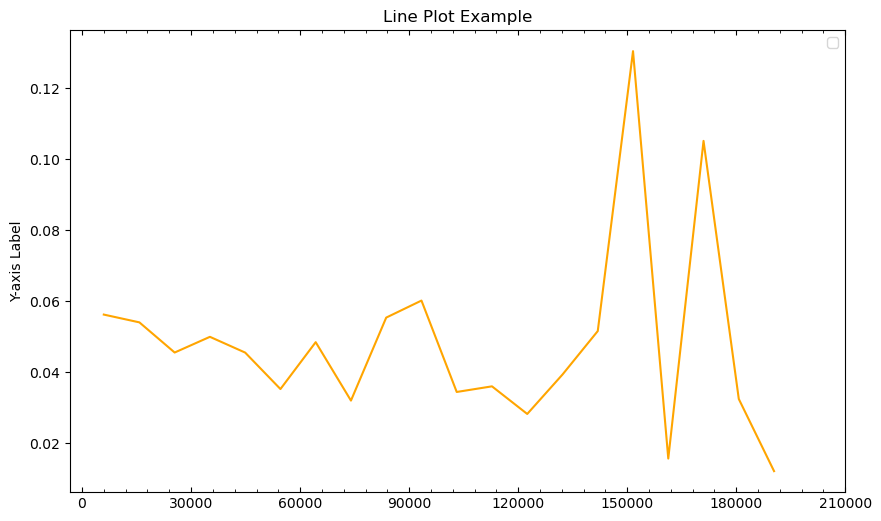

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, error_distribution_by_bin.values, color='orange')
plt.xlabel(None)
plt.ylabel('Y-axis Label')
plt.title('Line Plot Example')

ticks_with_labels = np.arange(0, 200000 + 30000, 30000)  # Adjust the number of ticks as needed
plt.xticks(ticks_with_labels, ha="center")

ticks_without_labels = np.arange(0, 200000 + 6000, 6000)  # Adjust the number of ticks as needed
plt.xticks(ticks_without_labels, [], minor=True)  # No labels
plt.tick_params(axis='x', which='minor', bottom=True, labelbottom=True, top=True, labeltop=False,\
                direction='in', length=plt.rcParams['xtick.major.size']*3/5)
plt.tick_params(axis='x', which='major', bottom=True, labelbottom=True, top=True, labeltop=False,\
                direction='in')

plt.legend()

plt.show()

In [17]:
from matplotlib.font_manager import FontProperties as font

def simple_line_plot(x_data, y_data, fig_size=(6,4.5), x_axis_label='X', y_axis_label='Y', label_fontsize=10,
                    plot_title=None, x_ticks_start=None, x_ticks_end=None, x_ticks_major_increment=None, 
                    x_ticks_nbr_minor_between_major=5, x_nbr_small_before_first=0, x_nbr_small_after_last=0, 
                    y_ticks_start=None, y_ticks_end=None, 
                    y_ticks_major_increment=None, y_ticks_nbr_minor_between_major=5, y_nbr_small_before_first=0,
                    y_nbr_small_after_last=0,
                    tick_fontsize=8, major_minor_ratio=5/3, line_color='orange', font_family='Times New Roman'):
    
    ticks_font_properties = font(family=font_family, style='italic', size=tick_fontsize)
    labels_font_properties = font(family=font_family, style='italic', size=label_fontsize)
    
    plt.figure(figsize=fig_size)
    plt.plot(x_data, y_data, color=line_color)
    
    plt.xlabel(x_axis_label, fontproperties=labels_font_properties)
    plt.ylabel(y_axis_label, fontproperties=labels_font_properties)
    plt.title(plot_title)

    if x_ticks_start is not None and x_ticks_end is not None and x_ticks_major_increment is not None:
        x_ticks_with_labels = np.arange(x_ticks_start, x_ticks_end+x_ticks_major_increment, x_ticks_major_increment)
        plt.xticks(x_ticks_with_labels, ha="center")

        x_small_ticks_increment = x_ticks_major_increment/x_ticks_nbr_minor_between_major
        x_ticks_without_labels = np.arange(x_ticks_start, x_ticks_end, x_small_ticks_increment)
        x_lower_bound = x_ticks_start - x_nbr_small_before_first*x_small_ticks_increment
        x_ticks_complement = np.arange(x_lower_bound, x_ticks_start, x_small_ticks_increment)
        x_small_ticks_final = np.sort(np.concatenate((x_ticks_complement, x_ticks_without_labels)))
        x_upper_bound = x_ticks_end + x_nbr_small_after_last*x_small_ticks_increment
        x_ticks_complement = np.arange(x_ticks_end, x_upper_bound, x_small_ticks_increment)
        x_small_ticks_final = np.sort(np.concatenate((x_small_ticks_final, x_ticks_complement))) 
        plt.xticks(x_small_ticks_final, [], minor=True)
    
    if y_ticks_start is not None and y_ticks_end is not None and y_ticks_major_increment is not None:
        y_ticks_with_labels = np.arange(y_ticks_start, y_ticks_end+y_ticks_major_increment, y_ticks_major_increment)
        plt.yticks(y_ticks_with_labels, ha="right")

        y_small_ticks_increment = y_ticks_major_increment/y_ticks_nbr_minor_between_major
        y_ticks_without_labels = np.arange(y_ticks_start, y_ticks_end, y_small_ticks_increment)
        y_lower_bound = y_ticks_start - y_nbr_small_before_first*y_small_ticks_increment
        y_ticks_complement = np.arange(y_lower_bound, y_ticks_start, y_small_ticks_increment)
        y_small_ticks_final = np.sort(np.concatenate((y_ticks_complement, y_ticks_without_labels)))
        y_upper_bound = y_ticks_end + y_nbr_small_after_last*y_small_ticks_increment
        y_ticks_complement = np.arange(y_ticks_end, y_upper_bound, y_small_ticks_increment)
        y_small_ticks_final = np.sort(np.concatenate((y_small_ticks_final, y_ticks_complement)))
        plt.yticks(y_small_ticks_final, [], minor=True)
    
    plt.xticks(fontproperties=ticks_font_properties)
    plt.yticks(fontproperties=ticks_font_properties)
    
#     plt.rc('xtick', labelsize=30) 
#     plt.rc('ytick', labelsize=tick_fontsize) 
    
    plt.tick_params(axis='both', which='minor', bottom=True, labelbottom=True, top=True, labeltop=False,\
                right=True, labelright=False, direction='in', length=plt.rcParams['xtick.major.size']*(1/major_minor_ratio))
    plt.tick_params(axis='both', which='major', bottom=True, labelbottom=True, top=True, labeltop=False,\
                right=True, labelright=False, direction='in')
    
    formatter = ticker.FuncFormatter(lambda x, _: "{:,.0f}".format(x))
    plt.gca().xaxis.set_major_formatter(formatter)
       
#    plt.legend()
    
    return plt.gcf()

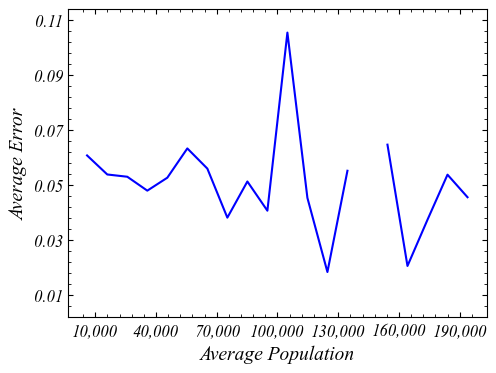

In [18]:
fig = simple_line_plot(bin_centers, error_distribution_by_bin.values, fig_size=(5.4,4), x_axis_label='Average Population', 
                 y_axis_label='Average Error',plot_title=None, x_ticks_start=10000, x_ticks_end=190000, 
                 x_ticks_major_increment=30000, x_ticks_nbr_minor_between_major=5, y_ticks_start=0.01, y_ticks_end=0.11, 
                 y_ticks_major_increment=0.02, y_ticks_nbr_minor_between_major=5, major_minor_ratio=5/3, line_color='blue',
                 tick_fontsize=12, label_fontsize=14, x_nbr_small_before_first=1, x_nbr_small_after_last=2,
                 y_nbr_small_before_first=2, y_nbr_small_after_last=2)

# Visualization of the feature importances

In [19]:
estimator = best_model.named_steps['model']
coefs_df = best_model.named_steps['squarer'].get_coefs_df(estimator)

In [20]:
def get_scaled_abs(df):
    df_abs = df.apply(lambda x: abs(x))
    max_value = df_abs.max().max()
    normalized_df = df_abs / max_value
    return normalized_df



final_coefs_df = get_scaled_abs(coefs_df)

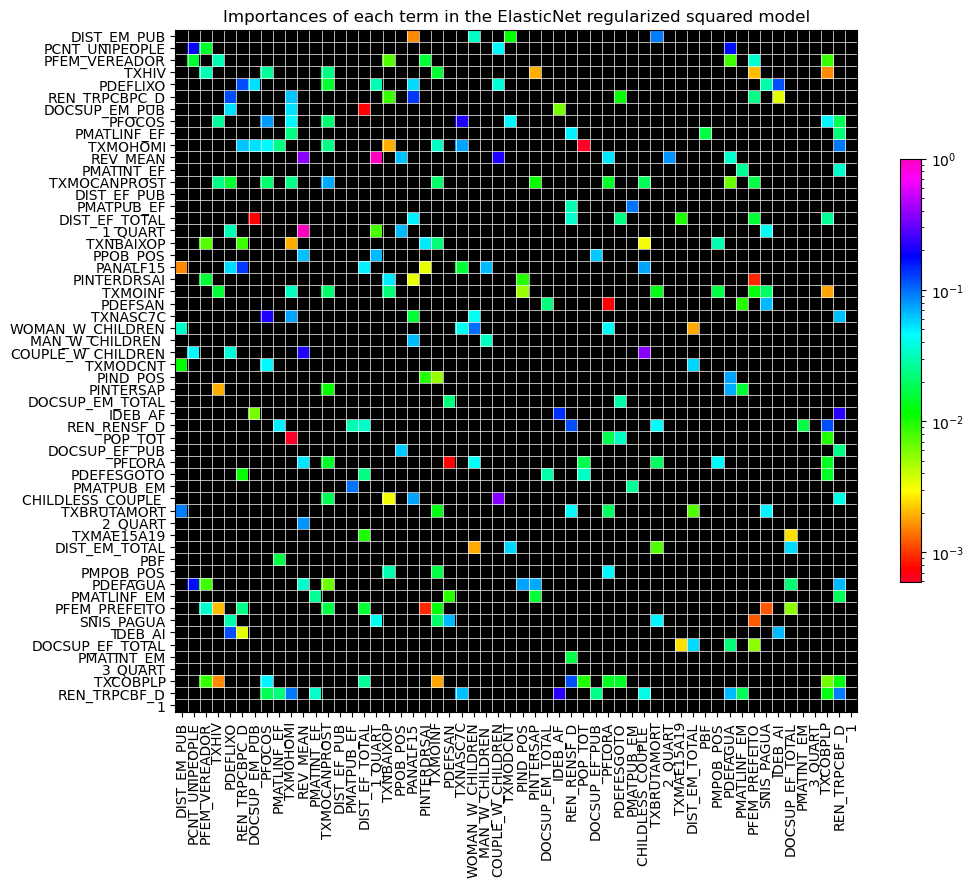

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

min_nonzero = final_coefs_df[final_coefs_df > 0].min().min()
    
cmap = plt.cm.gist_rainbow  
cmap.set_bad(color='black', alpha=1.0)

masked_array = np.ma.masked_where(final_coefs_df == 0, final_coefs_df)

plt.figure(figsize=(11, 11))
plt.imshow(masked_array, cmap=cmap, norm=LogNorm(vmin=min_nonzero, vmax=1), interpolation='nearest')
plt.colorbar(shrink=0.5)

plt.xticks(np.arange(len(final_coefs_df.columns)), final_coefs_df.columns, rotation=90)
plt.yticks(np.arange(len(final_coefs_df.index)), final_coefs_df.index)

num_rows, num_cols = final_coefs_df.shape
for i in range(num_rows + 1):
    plt.axhline(i - 0.5, color='white', linewidth=0.5)  
for j in range(num_cols + 1):
    plt.axvline(j - 0.5, color='white', linewidth=0.5) 

# plt.xlabel('Column')
# plt.ylabel('Index')
plt.title('Importances of each term in the ElasticNet regularized squared model')

plt.show()

In [24]:
top = final_coefs_df.stack().nlargest(32)
top_with_labels = top.reset_index()
top_with_labels.columns = ['Row', 'Column', 'Value']
top_with_labels

,Row,Column,Value
0,REV_MEAN,1_QUART,1.000000
1,1_QUART,REV_MEAN,1.000000
2,REV_MEAN,REV_MEAN,0.374389
3,COUPLE_W_CHILDREN,CHILDLESS_COUPLE,0.368510
4,CHILDLESS_COUPLE,COUPLE_W_CHILDREN,0.368510
5,IDEB_AF,REN_TRPCBF_D,0.221000
6,REN_TRPCBF_D,IDEB_AF,0.221000
7,REV_MEAN,COUPLE_W_CHILDREN,0.211921
8,COUPLE_W_CHILDREN,REV_MEAN,0.211921
9,PFOCOS,TXNASC7C,0.209334


In [38]:
most_important = top_with_labels['Row'].value_counts()

In [39]:
top_with_labels['Column'].value_counts()

REN_TRPCBF_D         3
REV_MEAN             3
REN_TRPCBPC_D        2
COUPLE_W_CHILDREN    2
IDEB_AF              2
PCNT_UNIPEOPLE       2
PDEFLIXO             2
REN_RENSF_D          2
TXCOBPLP             1
TXBRUTAMORT          1
TXMOHOMI             1
PMATPUB_EF           1
PMATPUB_EM           1
WOMAN_W_CHILDREN     1
1_QUART              1
IDEB_AI              1
PANALF15             1
PDEFAGUA             1
PFOCOS               1
TXNASC7C             1
CHILDLESS_COUPLE     1
DIST_EM_PUB          1
Name: Column, dtype: int64

In [40]:
most_important = pd.DataFrame(most_important.head(8)).index
most_important

Index(['REV_MEAN', 'REN_TRPCBF_D', 'REN_RENSF_D', 'COUPLE_W_CHILDREN',
       'IDEB_AF', 'PCNT_UNIPEOPLE', 'REN_TRPCBPC_D', 'PDEFLIXO'],
      dtype='object')

### Most important features in first test run for this
['REV_MEAN', 'REN_TRPCBF_D', 'REN_RENSF_D', 'COUPLE_W_CHILDREN', 'IDEB_AF', 'PCNT_UNIPEOPLE', 'REN_TRPCBPC_D', 'PDEFLIXO']

# Visualization of 'covariances'

In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

def load_model():
    params_dict = {'encoder__encoder_arg': 'one_hot',
               'imputing__fill_with': 0,
               'model__alpha': 0.0006928571428571428,
               'model__l1_ratio': 0.7357142857142858,
               'squarer__degree': 2}

    cat_columns = ['SG_UF']
    imputing = Imputer()
    squarer = PolyTransformer(cat_attributes=cat_columns, rename=True)
    encoder = Encoder(cat_attributes=cat_columns)
    std_scaler = StandardScaler()
    elastic_net = ElasticNet(max_iter=2000, tol=1e-3)

    best_model = Pipeline([('imputing', imputing), ('squarer', squarer), ('encoder', encoder), \
                     ('scaler', std_scaler), ('model', elastic_net)])

    best_model.set_params(**params_dict)
    
    X = pd.read_json('C:/Users/betob/Dropbox/Data_Science/Projects/2 -- Elections 2022/preprocessed_elections_data_X.json')
    y = pd.read_json('C:/Users/betob/Dropbox/Data_Science/Projects/2 -- Elections 2022/preprocessed_elections_data_y.json')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    absolute_error = abs(y_test.values.reshape(-1) - y_pred)
    
    return best_model, X_test, y_pred, absolute_error

In [43]:
model, X_test, y_pred, absolute_error = load_model()

C:\Users\betob\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


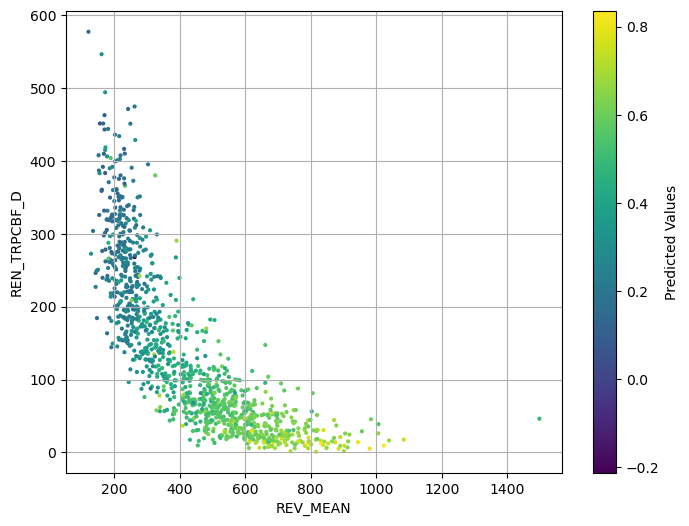

In [52]:
col_1 = 'REV_MEAN'
col_2 = 'REN_TRPCBF_D'

plt.figure(figsize=(8, 6))
plt.scatter(X_test[col_1], X_test[col_2], c=y_pred, cmap='viridis', s=4)
plt.colorbar(label='Predicted Values')
plt.xlabel(col_1)
plt.ylabel(col_2)
#plt.title('Predictions based on Column1 and Column2')
plt.grid(True)
plt.show()

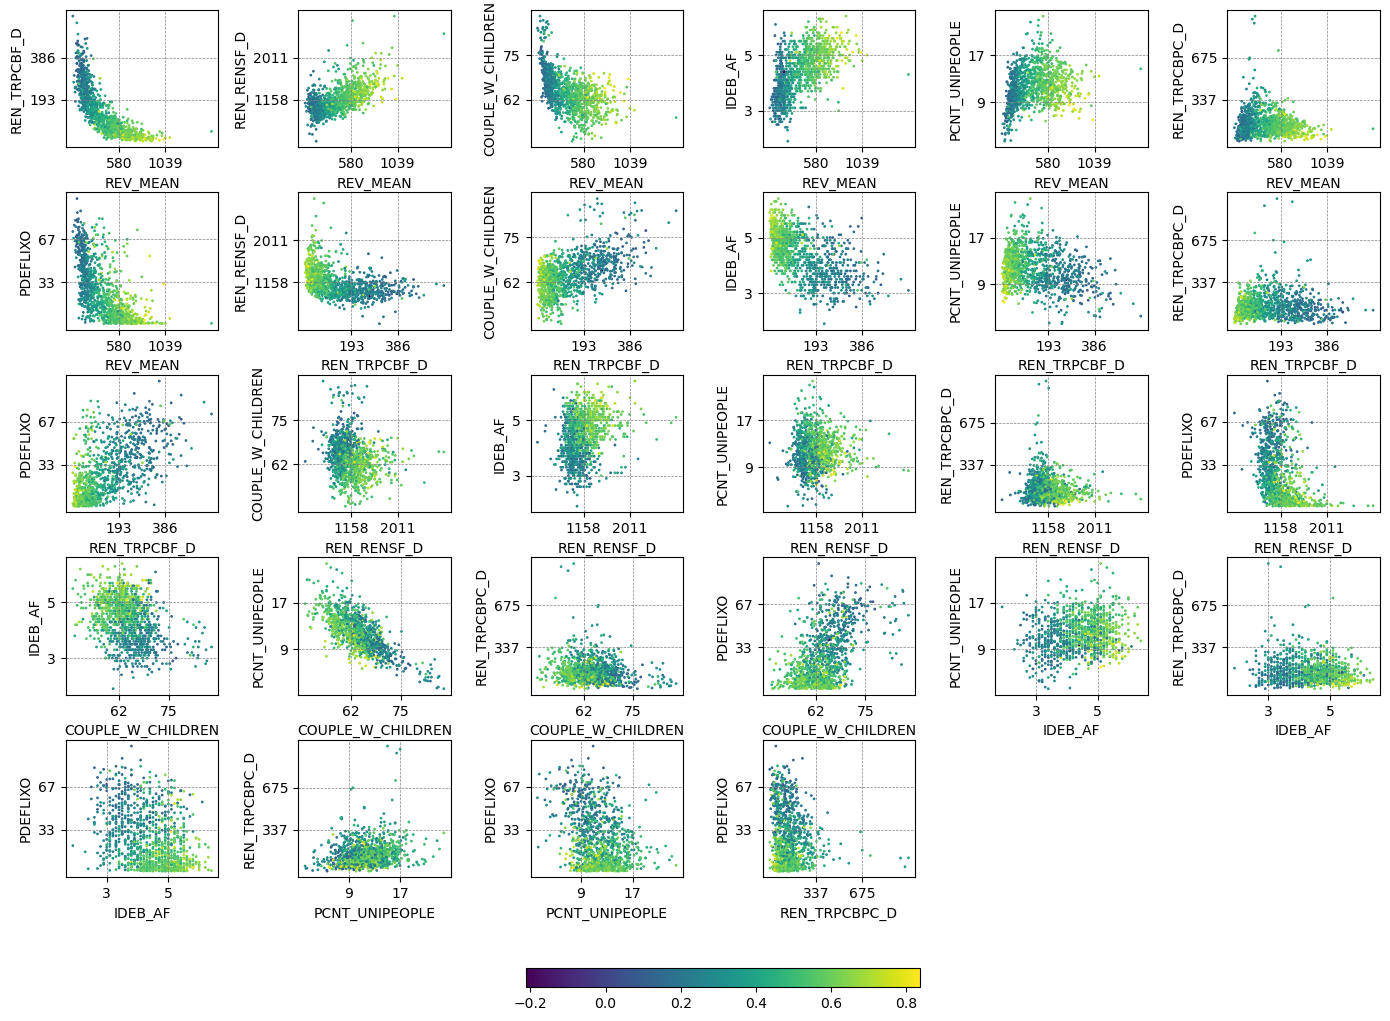

In [109]:
import math

features_list = ['REV_MEAN', 'REN_TRPCBF_D', 'REN_RENSF_D', 'COUPLE_W_CHILDREN', 'IDEB_AF', 
                 'PCNT_UNIPEOPLE', 'REN_TRPCBPC_D', 'PDEFLIXO']


# Create a matrix of plots
fig, axes = plt.subplots(5, 6, figsize=(14, 12))

l = 0
k = 0
for i, feature1 in enumerate(features_list):
    for j, feature2 in enumerate(features_list):
        if i < j:
            scatter = axes[l, k].scatter(X_test[feature1], X_test[feature2], c=y_pred, cmap='viridis', s=1)
            axes[l, k].set_xlabel(feature1)
            axes[l, k].set_ylabel(feature2)
            
            x_range = X_test[feature1].max() - X_test[feature1].min()
            y_range = X_test[feature2].max() - X_test[feature2].min()
            x_ticks = list(map(int,[X_test[feature1].min() + x_range / 3, X_test[feature1].min() + 2 * x_range / 3]))
            y_ticks = list(map(int,[X_test[feature2].min() + y_range / 3, X_test[feature2].min() + 2 * y_range / 3]))
            
            x_ticks = [int(X_test[feature1].min() + x_range / 3), math.ceil(X_test[feature1].min() + 2 * x_range / 3)]
            y_ticks = [int(X_test[feature2].min() + y_range / 3), math.ceil(X_test[feature2].min() + 2 * y_range / 3)]
            axes[l, k].set_xticks(x_ticks)
            axes[l, k].set_yticks(y_ticks)
            
            axes[l, k].grid(True, linestyle='--', linewidth=0.5, color='gray')  # Add grid
            
            k += 1
            if k == 6:
                l += 1
                k = 0
                
fig.delaxes(axes[4, 4])
fig.delaxes(axes[4, 5])

plt.tight_layout()

cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', pad=0.08, shrink=0.3, location='bottom')

plt.show()